# The Efficient Frontier
***
Portfolio Theory suggest that we can maximise risk to return in any portfolio by exploiting the correlation between the constituting securities. 

In this notebook, we will first derive our bullet portfolio graph that displays a scatter plot of daily-return data points. 

Next, we will plot the efficient frontier showcasing the highest return an investor can receive for each level of volatility. In other words, we can investigate which portfolio mix generates the highest Sharpe Ratio

**Libraries required: Pandas, Numpy, Matplotlib & SciPy**


In [1]:
# Let's import the necessary libraries

from scipy.optimize import minimize
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Creating a dataframe consisting of the adjusted close price of our 4 stocks

aapl = pd.read_csv('AAPL_CLOSE', index_col = "Date" , parse_dates = True)
cisco = pd.read_csv('CISCO_CLOSE', index_col = "Date" , parse_dates = True)
ibm = pd.read_csv('IBM_CLOSE', index_col = "Date" , parse_dates = True)
amzn = pd.read_csv('AMZN_CLOSE', index_col = "Date" , parse_dates = True)

stocks = pd.concat([aapl,cisco,ibm, amzn],axis = 1) # combined dataframe
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn'] # renaming columns
stocks.head(10)

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56
2012-01-10,54.612933,15.921890,156.523065,179.34
2012-01-11,54.523898,16.124824,157.394988,178.90
2012-01-12,54.374217,16.192469,155.866965,175.93
2012-01-13,54.170341,16.116369,154.666992,178.42


In [3]:
print("Below shows the correlation bewteen the daily returns of the securities")
stocks.pct_change(1).corr()

Below shows the correlation bewteen the daily returns of the securities


,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


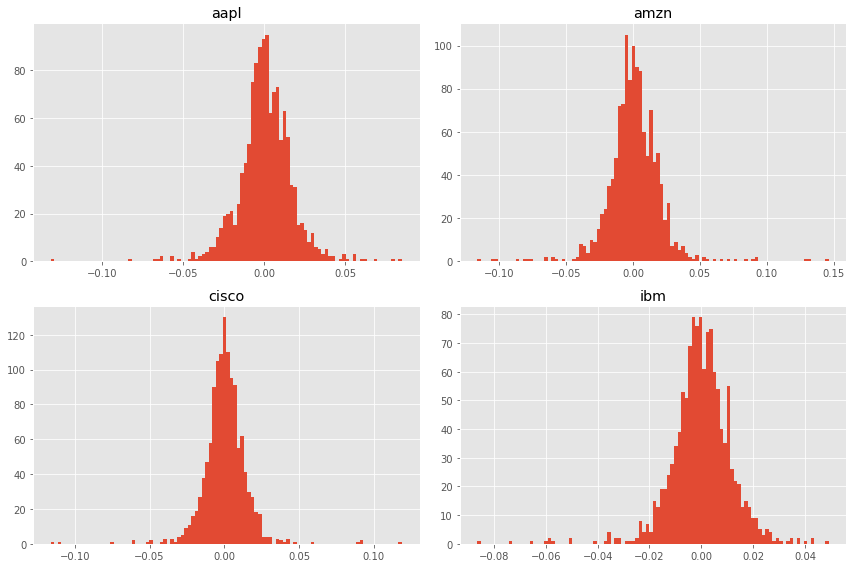

In [4]:
# Visualization of the log return of each security 
log_return = np.log(stocks/stocks.shift(1))
log_return.hist(bins=100, figsize = (12,8))
plt.tight_layout()

In [5]:
######### A distribution of allocation #########3

np.random.seed(101)

num_ports = 5000 # number of portfolios
all_weights = np.zeros((num_ports,len(stocks.columns)))   # .zeros() can accept a tuple to form multi-dimensional data
# Arrays
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)


# Using iteration - attach an allocation, return and volatiliy for each portfolio 
# in this case there are 5000 portfolios
for ind in range(num_ports):         # for each index in range(num_ports)
    
        # weights
        weights = np.array(np.random.random(4)) # an array of the 4 allocations
        weights = weights/np.sum(weights)

        # save weights
        all_weights[ind,:] = weights    # using Numpy broadcasting to all along the axis with :
        # shows all weights for that particular index

        # expected return of PORTFOLIO
        ret_arr[ind] = np.sum((log_return.mean()*weights)*252)

        # expected volatility of PORTFOLIO
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252,weights)))

        # sharpe ratio of PORTFOLIO
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
        

In [6]:
# now that we have our 5000 data point, let us find out the point with the higest sharpe ratio
print(sharpe_arr.max())
print(sharpe_arr.argmax())
all_weights[1420,:]   # this is the allocation with the highest sharpe ratio

1.0303260551271067
1420


array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

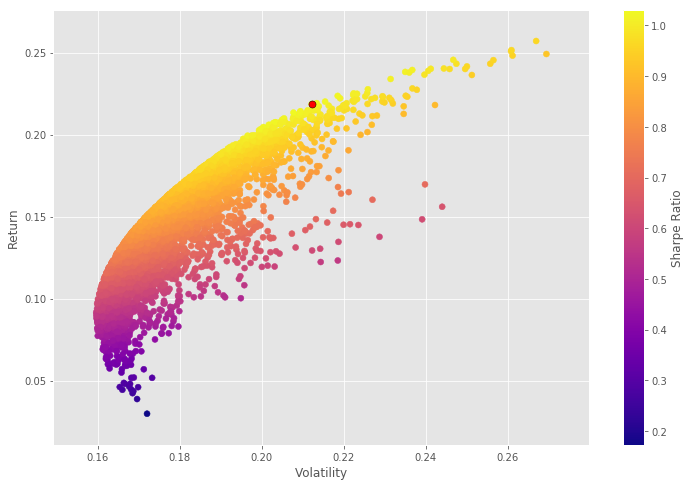

In [7]:
plt.figure(figsize = (12,8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr , cmap = 'plasma')
plt.colorbar(label = "Sharpe Ratio") # colorbar linked to c argument in scatter()

plt.xlabel('Volatility')
plt.ylabel('Return')


####### Pointing out the optimized allocation  #######
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]
plt.scatter(max_sr_vol,max_sr_ret,c = 'r', s=50, edgecolors='black')

***

## Optimization
We have a scatter plot of portfolio data points, but things only get interesting when we carry out optimization

In [8]:
# Let us create a function that outputs an array for the return, volatility and sharpe ratio for a specific portfolio
# this is done so that we can carry out optimization

def get_ret_vol_sr(weights): 
    weights = np.array(weights)  # just to make sure the weghts are an array
    ret = np.sum((log_return.mean()*weights)*252)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [9]:

# minimize sharpe ratio, w.r.t weights
def neg_sharpe(weights):    # passing in a function into a function
    return get_ret_vol_sr(weights)[2] * -1   # take index 2 of the array which is SR, and then make it negative

def check_sum(weights): 
    return np.sum(weights) - 1 
    # return zero if the sum of the weight is 1.0
    
# lets create a constraints tuple
cons = ({'type':'eq', 'fun': check_sum})
# as you see there is only ONE constraint
# type is equation
# function is check_sum

# bounds of each weight
bounds = ((0,1),(0,1),(0,1),(0,1))

init_guess = [0.25,0.25,0.25,0.25]



######### MINIMIZE THE NEG_SHARPE FUNCTION ##########
# see documetation for the arguments
opt_results = minimize(neg_sharpe,init_guess,method="SLSQP", bounds= bounds, constraints= cons)

opt_results


     fun: -1.030716870336087
     jac: array([ 5.64157963e-05,  4.18275595e-05,  3.39921713e-01, -4.44799662e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289762e-01, 2.04189824e-01, 3.43149988e-17, 5.29520414e-01])

In [10]:
# this is array of return, volume and sharpe ratio of the optimized portfolio
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

***

## Plotting the Frontier
Let us depict a line that demonstrates the highest possible return for each level of volatility


In [11]:
frontier_y = np.linspace(0,0.3,100)
frontier_vol = []

# function to be minimized: minimizes volatility, w.r.t weights
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

for possible_ret in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
               {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_ret})
    result = minimize(minimize_vol, init_guess, method ="SLSQP", bounds = bounds, constraints = cons)
    
    frontier_vol.append(result['fun'])

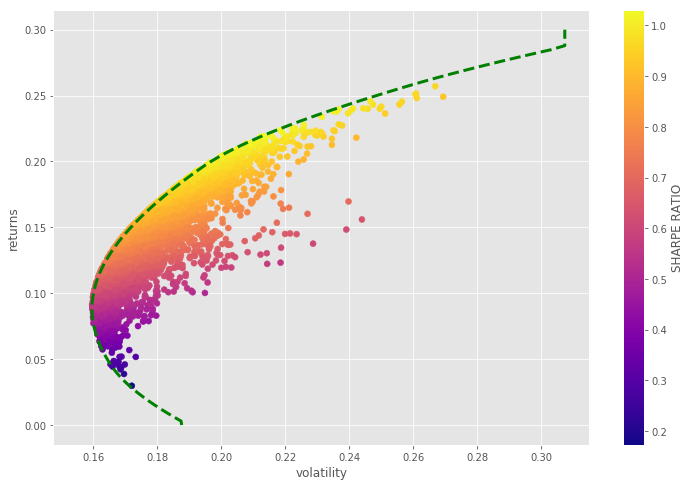

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap="plasma")
plt.colorbar(label="SHARPE RATIO")
plt.xlabel('volatility')
plt.ylabel('returns')
# same as before



# The Efficient Frontier
plt.plot(frontier_vol,frontier_y, 'g--',linewidth= 3)

***